In [1]:
import pandas as pd
import requests
import datetime
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('S3_ironman_elevation_updated.csv')
print(f"Loaded {len(df)} races")
print(f"Number of unique locations: {df['Location'].nunique()}")

Loaded 306 races
Number of unique locations: 110


In [4]:
missing_values = df.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])



Columns with missing values:
bike_elevation          3
run_elevation           3
max_temperature       306
temperature_10AM      306
min_temperature       306
relative_humidity     306
average_wind_speed    306
average_pressure      306
cloud_coverage        306
water_temperature     306
solar_radiation       306
WBGT                  306
dtype: int64


In [5]:
def parse_date(date_str):
    try:
        # Parse date in m/d/yyyy format
        date_obj = datetime.datetime.strptime(date_str, '%m/%d/%Y')
        # Return in yyyy-mm-dd format
        return date_obj.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"Error parsing date {date_str}: {e}")
        return None

In [6]:
df['api_date'] = df['Date'].apply(parse_date)

In [7]:
df[['Date', 'api_date']].head()

,Date,api_date
0,6/26/2016,2016-06-26
1,6/18/2023,2023-06-18
2,9/19/2021,2021-09-19
3,7/7/2019,2019-07-07
4,7/3/2022,2022-07-03


In [8]:
def get_historical_weather(latitude, longitude, date):
    """Fetch historical weather data from Open-Meteo API
    
    Args:
        latitude (float): Location latitude
        longitude (float): Location longitude
        date (str): Date in yyyy-mm-dd format
        
    Returns:
        dict: Weather data or None if request failed
    """
    # Base URL for historical data
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    
    # Parameters for the API request
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": date,
        "end_date": date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "rain_sum",
                 "weathercode", "windspeed_10m_max", "windgusts_10m_max", "winddirection_10m_dominant"],
        "hourly": ["temperature_2m", "relativehumidity_2m", "pressure_msl", 
                  "cloudcover", "windspeed_10m", "direct_radiation", "diffuse_radiation"],
        "timezone": "auto"
    }
    
    try:
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            return data
        else:
            print(f"API request failed with status code {response.status_code}: {response.text}")
            return None
    except Exception as e:
        print(f"Error making API request: {e}")
        return None



def process_weather_data(api_response):
    """Extract relevant weather metrics from Open-Meteo API response
    
    Args:
        api_response (dict): Response from Open-Meteo API
        
    Returns:
        dict: Extracted weather metrics
    """
    if not api_response or 'hourly' not in api_response or 'daily' not in api_response:
        return {}
    
    weather_data = {}
    
    # Daily metrics
    daily = api_response['daily']
    weather_data['max_temperature'] = daily['temperature_2m_max'][0]  # Max temperature (°C)
    weather_data['min_temperature'] = daily['temperature_2m_min'][0]  # Min temperature (°C)
    
    # Hourly metrics - get 10AM data (hour 10)
    hourly = api_response['hourly']
    # Find the index for 10:00 AM
    hour_10_index = None
    for i, time in enumerate(hourly['time']):
        if time.endswith('T10:00'):
            hour_10_index = i
            break
    
    if hour_10_index is not None:
        weather_data['temperature_10AM'] = hourly['temperature_2m'][hour_10_index]  # Temp at 10 AM (°C)
        weather_data['relative_humidity'] = hourly['relativehumidity_2m'][hour_10_index]  # RH at 10 AM (%)
        weather_data['cloud_coverage'] = hourly['cloudcover'][hour_10_index]  # Cloud cover at 10 AM (%)
        
    # Calculate daily averages
    weather_data['average_wind_speed'] = sum(hourly['windspeed_10m']) / len(hourly['windspeed_10m'])  # Avg wind speed (km/h)
    weather_data['average_pressure'] = sum(hourly['pressure_msl']) / len(hourly['pressure_msl'])  # Avg pressure (hPa)
    
    # Calculate solar radiation (average of direct + diffuse during daylight hours)
    if 'direct_radiation' in hourly and 'diffuse_radiation' in hourly:
        # Only consider daylight hours (where radiation > 0)
        direct = np.array(hourly['direct_radiation'])
        diffuse = np.array(hourly['diffuse_radiation'])
        total_radiation = direct + diffuse
        daylight_radiation = total_radiation[total_radiation > 0]
        if len(daylight_radiation) > 0:
            weather_data['solar_radiation'] = daylight_radiation.mean()  # Average solar radiation (W/m²)
    
    return weather_data

In [9]:
test_row = df.iloc[0]
print(f"Testing with: {test_row['Location']} on {test_row['Date']} (API Date: {test_row['api_date']})")


Testing with: Klagenfurt, Austria on 6/26/2016 (API Date: 2016-06-26)


In [10]:
api_response = get_historical_weather(test_row['latitude'], test_row['longitude'], test_row['api_date'])

if api_response:
    print("API request successful!")
    weather_data = process_weather_data(api_response)
    print("\nExtracted weather data:")
    for key, value in weather_data.items():
        print(f"{key}: {value}")
else:
    print("API request failed - please check your internet connection or API availability")


# Fetch weather data for each race with rate limiting to avoid API blocks
def fetch_all_weather_data(df, max_rows=None):
    """Fetch weather data for races in the dataframe
    
    Args:
        df (pandas.DataFrame): Dataframe with race information
        max_rows (int, optional): Maximum number of rows to process. If None, process all rows.
        
    Returns:
        pandas.DataFrame: Updated dataframe with weather data
    """
    # Create a copy of the dataframe to avoid modifying the original
    result_df = df.copy()
    
    # Keep track of races processed
    processed = 0
    success_count = 0
    
    # Determine how many rows to process
    rows_to_process = len(result_df) if max_rows is None else min(max_rows, len(result_df))
    subset_df = result_df.iloc[:rows_to_process]
    
    # Loop through each race
    for idx in tqdm(subset_df.index, desc="Fetching weather data"):
        # Get location and date information
        lat = result_df.at[idx, 'latitude']
        lon = result_df.at[idx, 'longitude']
        date = result_df.at[idx, 'api_date']
        location = result_df.at[idx, 'Location']
        
        # Skip if date is not valid
        if pd.isna(date) or not date:
            print(f"Skipping row {idx} due to invalid date")
            continue
            
        # Make API request
        api_response = get_historical_weather(lat, lon, date)
        
        # Process response and update dataframe
        if api_response:
            weather_data = process_weather_data(api_response)
            
            # Update dataframe with weather data
            for col, value in weather_data.items():
                if col in result_df.columns:
                    result_df.at[idx, col] = value
            
            success_count += 1
        else:
            print(f"Failed to retrieve data for {location} on {date}")
        
        # Increment counter
        processed += 1
        
        # Add a delay every 5 requests to avoid rate limiting
        if processed % 5 == 0:
            time.sleep(1)  # Sleep for 1 second
    
    print(f"Successfully retrieved data for {success_count} out of {processed} races.")
    return result_df

# First process a small sample to test (10 races)
print("Processing sample data (first 10 races)...")
sample_size = 10
updated_sample_df = fetch_all_weather_data(df, max_rows=sample_size)

# Show the results of the sample
print("\nSample results:")
updated_sample_df[['Location', 'Date', 'max_temperature', 'min_temperature', 
                   'relative_humidity', 'average_wind_speed']].head(sample_size)

API request successful!

Extracted weather data:
max_temperature: 24.2
min_temperature: 16.8
temperature_10AM: 22.1
relative_humidity: 71
cloud_coverage: 78
average_wind_speed: 6.133333333333332
average_pressure: 1014.6541666666668
solar_radiation: 327.4375
Processing sample data (first 10 races)...


Fetching weather data:   0%|          | 0/10 [00:00<?, ?it/s]

Successfully retrieved data for 10 out of 10 races.

Sample results:


,Location,Date,max_temperature,min_temperature,relative_humidity,average_wind_speed
0,"Klagenfurt, Austria",6/26/2016,24.2,16.8,71.0,6.133333
1,"Klagenfurt, Austria",6/18/2023,27.0,11.0,73.0,4.633333
2,"Klagenfurt, Austria",9/19/2021,19.9,10.5,69.0,4.320833
3,"Klagenfurt, Austria",7/7/2019,26.0,16.0,76.0,4.800000
4,"Klagenfurt, Austria",7/3/2022,29.3,15.8,71.0,3.637500
5,"Klagenfurt, Austria",7/2/2017,22.0,14.0,56.0,4.412500
6,"Klagenfurt, Austria\r\n",7/1/2018,21.9,13.6,60.0,9.287500
7,"The Woodlands, Texas",4/22/2017,24.7,15.0,80.0,15.216667
8,"The Woodlands, Texas",4/28/2018,27.0,11.5,55.0,5.579167
9,"The Woodlands, Texas, USA",10/9/2021,29.6,18.2,80.0,9.816667


In [13]:
process_full = input("Process the full dataset? (yes/no): ")
process_full = 'yes'
if process_full.lower() == 'yes':
    print("\nProcessing the full dataset (this may take some time)...")
    updated_df = fetch_all_weather_data(df)
    
    # Display summary of filled values
    filled_count = {}
    for col in ['max_temperature', 'min_temperature', 'temperature_10AM', 'relative_humidity', 
                'average_wind_speed', 'average_pressure', 'cloud_coverage', 'solar_radiation']:
        filled_count[col] = updated_df[col].notnull().sum()
    
    print("\nNumber of filled values per column:")
    for col, count in filled_count.items():
        print(f"{col}: {count} out of {len(updated_df)} ({count/len(updated_df)*100:.1f}%)")
else:
    print("Full dataset processing skipped.")
    # Make a copy so the next cells still work
    updated_df = updated_sample_df.copy()

# Save the updated dataframe to a new CSV file
output_filename = 'S3_ironman_elevation_weather_updated.csv'
updated_df.to_csv(output_filename, index=False)
print(f"Updated data saved to {output_filename}")



Processing the full dataset (this may take some time)...


Fetching weather data:   0%|          | 0/306 [00:00<?, ?it/s]

Successfully retrieved data for 306 out of 306 races.

Number of filled values per column:
max_temperature: 306 out of 306 (100.0%)
min_temperature: 306 out of 306 (100.0%)
temperature_10AM: 306 out of 306 (100.0%)
relative_humidity: 306 out of 306 (100.0%)
average_wind_speed: 306 out of 306 (100.0%)
average_pressure: 306 out of 306 (100.0%)
cloud_coverage: 306 out of 306 (100.0%)
solar_radiation: 306 out of 306 (100.0%)
Updated data saved to S3_ironman_elevation_weather_updated.csv


c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
) missing from current font.Temp\ipykernel_3416\3258525717.py:43: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


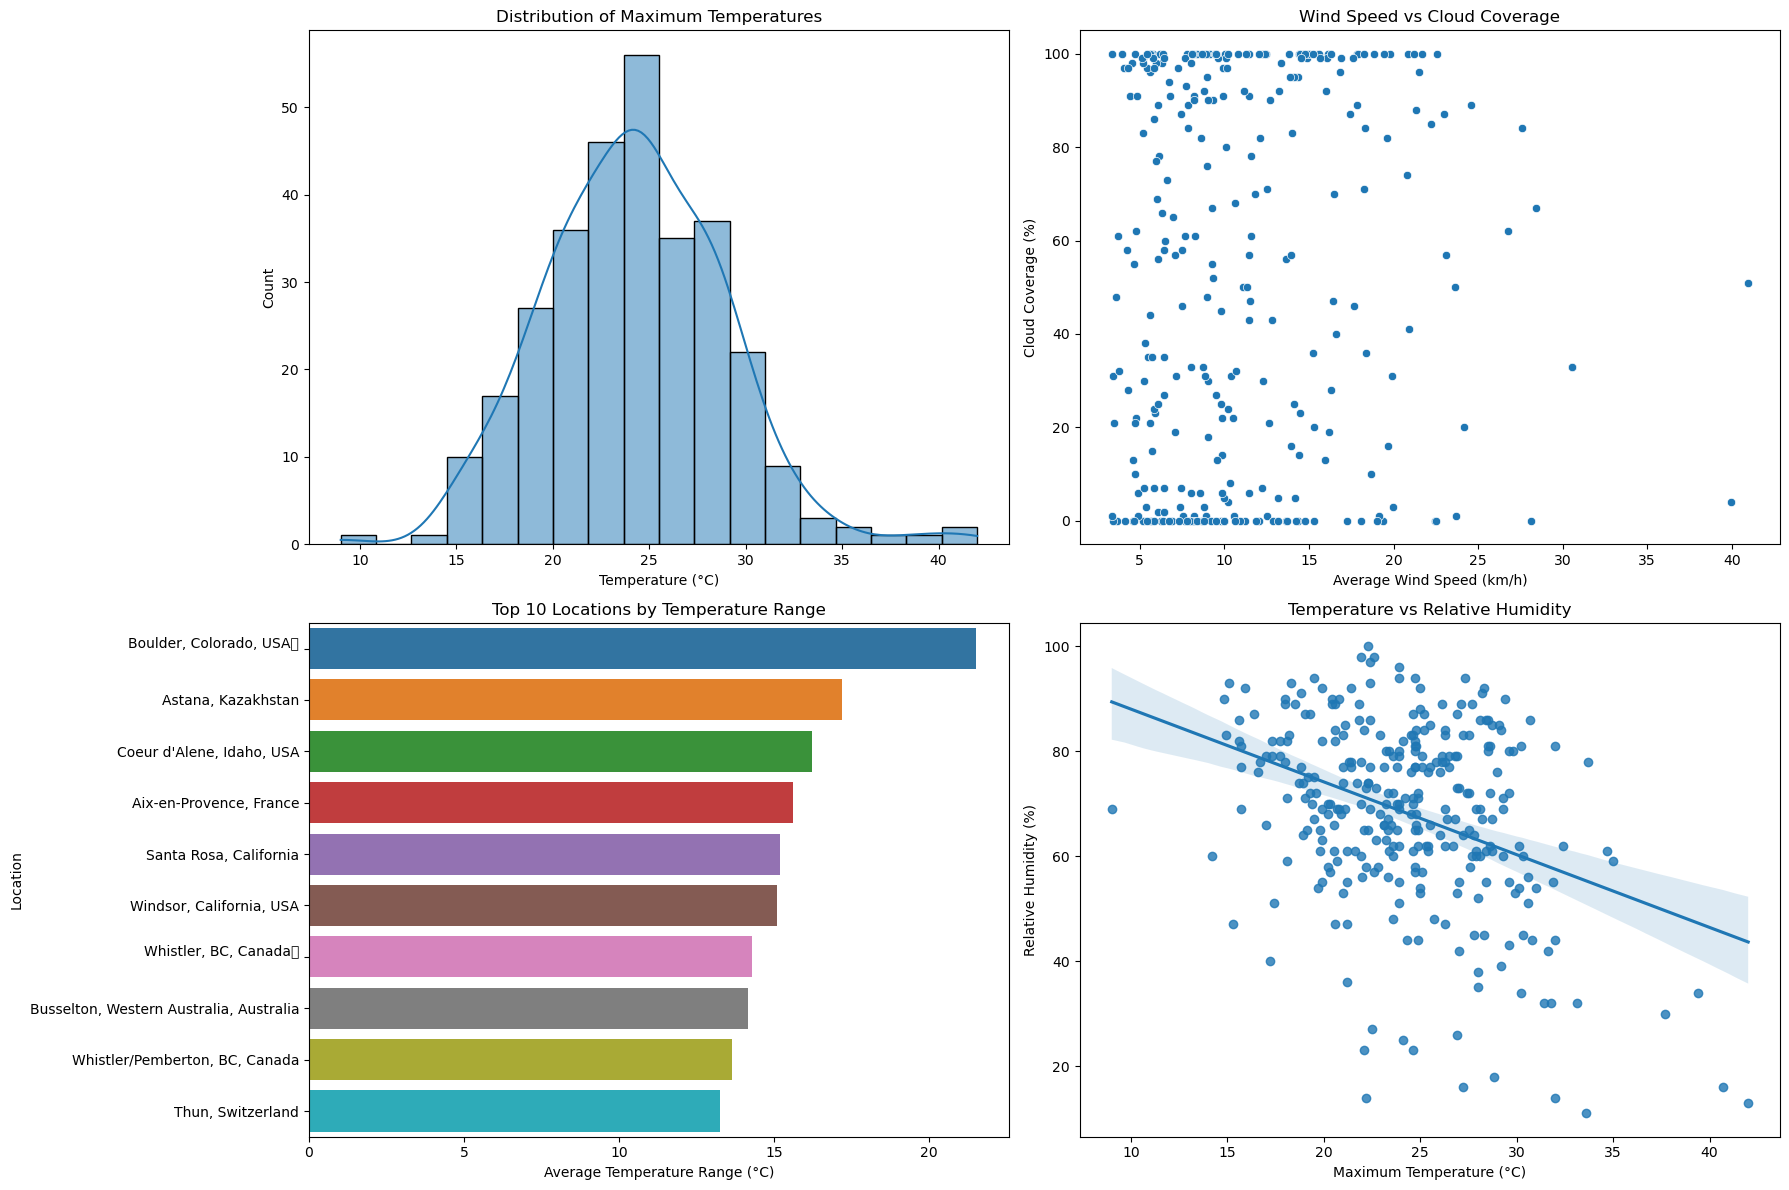

c:\Users\VAIO\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


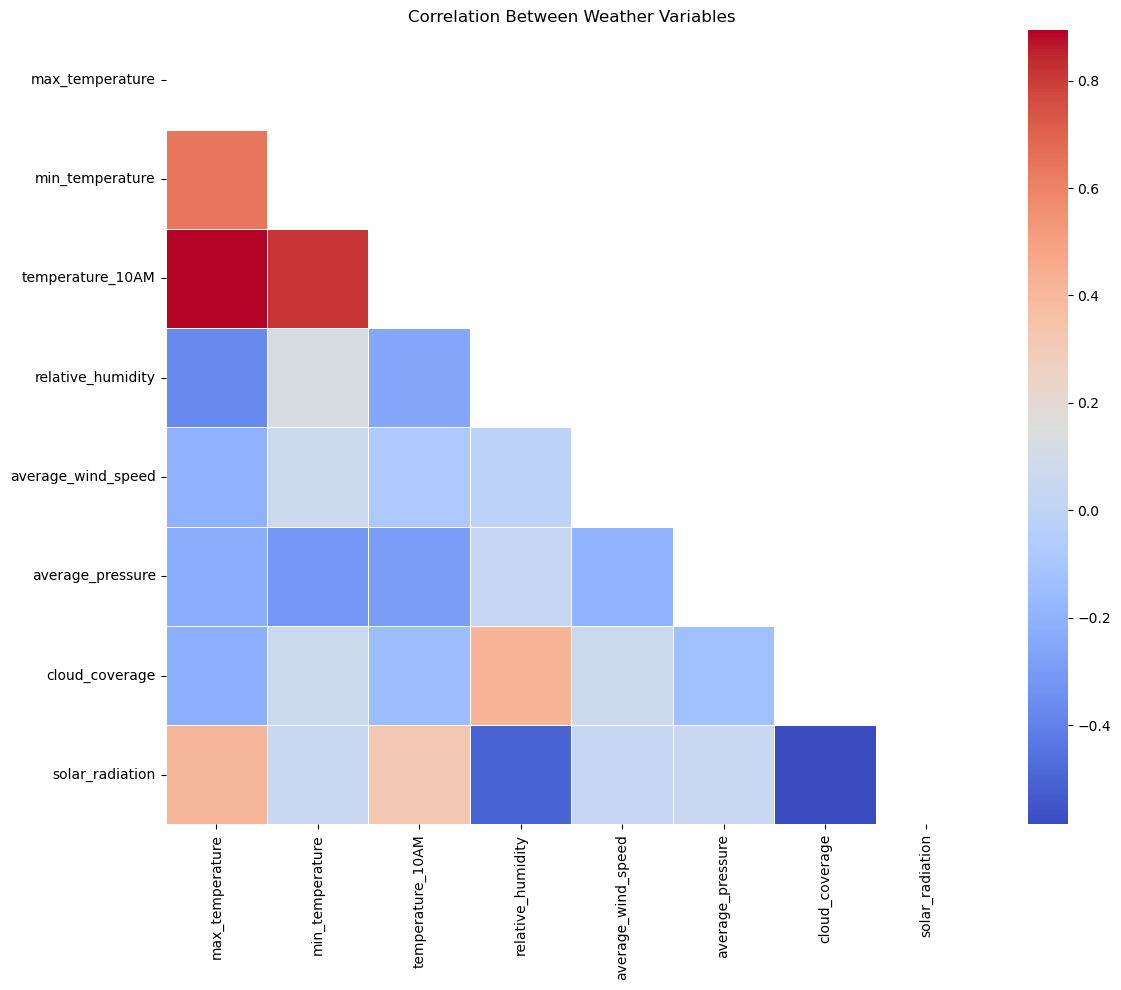

) missing from current font.Temp\ipykernel_3416\3258525717.py:124: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


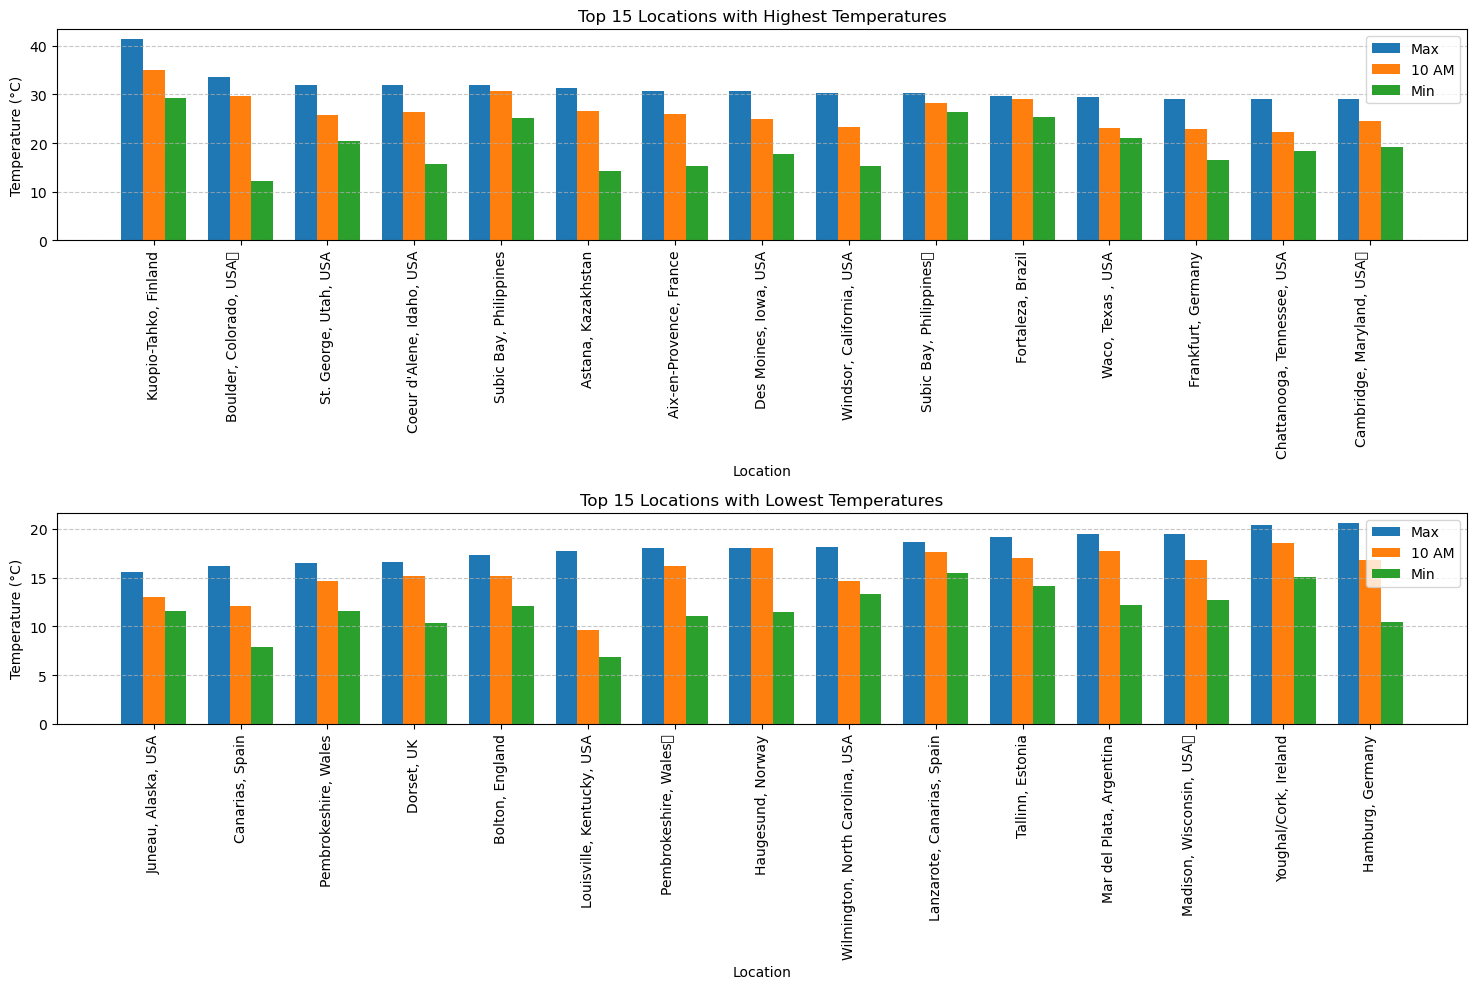

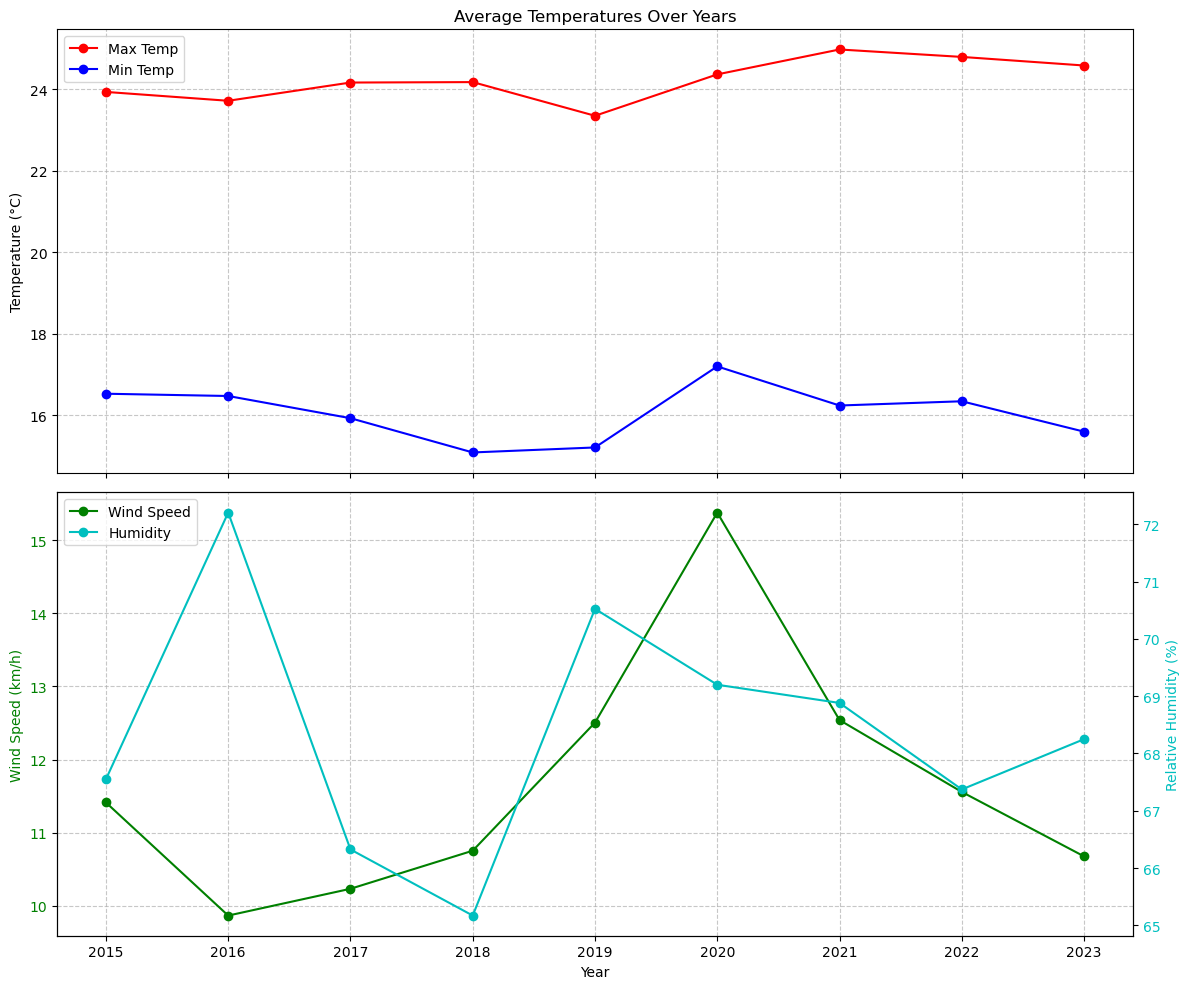

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
## Data Visualization
updated_df = pd.read_csv('S3_ironman_elevation_weather_updated.csv')
# Create some visualizations to explore the retrieved weather data
if updated_df['max_temperature'].notnull().sum() > 0:
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Distribution of maximum temperatures
    plt.subplot(2, 2, 1)
    sns.histplot(updated_df['max_temperature'].dropna(), kde=True)
    plt.title('Distribution of Maximum Temperatures')
    plt.xlabel('Temperature (°C)')
    
    # Plot 2: Average wind speed vs cloud coverage
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=updated_df.dropna(subset=['average_wind_speed', 'cloud_coverage']), 
                   x='average_wind_speed', y='cloud_coverage')
    plt.title('Wind Speed vs Cloud Coverage')
    plt.xlabel('Average Wind Speed (km/h)')
    plt.ylabel('Cloud Coverage (%)')
    
    # Plot 3: Temperature variation (max - min) by location (top 10 locations)
    plt.subplot(2, 2, 3)
    temp_variation = updated_df.dropna(subset=['max_temperature', 'min_temperature']).copy()
    temp_variation['temp_range'] = temp_variation['max_temperature'] - temp_variation['min_temperature']
    top_locations = temp_variation.groupby('Location')['temp_range'].mean().nlargest(10)
    
    sns.barplot(x=top_locations.values, y=top_locations.index)
    plt.title('Top 10 Locations by Temperature Range')
    plt.xlabel('Average Temperature Range (°C)')
    
    # Plot 4: Correlation between max temperature and relative humidity
    plt.subplot(2, 2, 4)
    sns.regplot(data=updated_df.dropna(subset=['max_temperature', 'relative_humidity']), 
               x='max_temperature', y='relative_humidity')
    plt.title('Temperature vs Relative Humidity')
    plt.xlabel('Maximum Temperature (°C)')
    plt.ylabel('Relative Humidity (%)')
    
    plt.tight_layout()
    plt.show()
else:
    print("No weather data available for visualization")

# Create a correlation heatmap for numerical columns
weather_cols = ['max_temperature', 'min_temperature', 'temperature_10AM', 
               'relative_humidity', 'average_wind_speed', 'average_pressure', 
               'cloud_coverage', 'solar_radiation']

# Filter columns that have data
available_cols = [col for col in weather_cols if updated_df[col].notnull().sum() > 0]

if len(available_cols) > 1:  # Need at least 2 columns for correlation
    # Calculate correlation matrix
    corr_matrix = updated_df[available_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
               linewidths=0.5, mask=mask)
    plt.title('Correlation Between Weather Variables')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data columns for correlation analysis")

## Analysis of Temperature by Race Location


# Analyze temperature by location
if updated_df['max_temperature'].notnull().sum() > 0:
    # Group by location and calculate average temperatures
    location_temps = updated_df.groupby('Location').agg({
        'max_temperature': 'mean',
        'min_temperature': 'mean',
        'temperature_10AM': 'mean'
    }).reset_index()
    
    # Sort by max temperature
    location_temps_sorted = location_temps.sort_values('max_temperature', ascending=False)
    
    # Plot top 15 hottest and coldest locations
    plt.figure(figsize=(15, 10))
    
    # Top 15 hottest
    plt.subplot(2, 1, 1)
    top_hot = location_temps_sorted.head(15)
    
    x = np.arange(len(top_hot))
    width = 0.25
    
    plt.bar(x - width, top_hot['max_temperature'], width, label='Max')
    plt.bar(x, top_hot['temperature_10AM'], width, label='10 AM')
    plt.bar(x + width, top_hot['min_temperature'], width, label='Min')
    
    plt.xlabel('Location')
    plt.ylabel('Temperature (°C)')
    plt.title('Top 15 Locations with Highest Temperatures')
    plt.xticks(x, top_hot['Location'], rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Top 15 coldest
    plt.subplot(2, 1, 2)
    top_cold = location_temps_sorted.tail(15).iloc[::-1]  # Reverse to show coldest first
    
    x = np.arange(len(top_cold))
    
    plt.bar(x - width, top_cold['max_temperature'], width, label='Max')
    plt.bar(x, top_cold['temperature_10AM'], width, label='10 AM')
    plt.bar(x + width, top_cold['min_temperature'], width, label='Min')
    
    plt.xlabel('Location')
    plt.ylabel('Temperature (°C)')
    plt.title('Top 15 Locations with Lowest Temperatures')
    plt.xticks(x, top_cold['Location'], rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("No temperature data available for analysis")

# Additional analysis: Weather conditions across different years
if updated_df['max_temperature'].notnull().sum() > 0:
    # Extract year from api_date
    updated_df['year'] = updated_df['api_date'].str[:4].astype(int)
    
    # Group by year and calculate average values
    yearly_weather = updated_df.groupby('year').agg({
        'max_temperature': 'mean',
        'min_temperature': 'mean',
        'average_wind_speed': 'mean',
        'relative_humidity': 'mean',
    }).reset_index()
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Temperature plot
    ax1.plot(yearly_weather['year'], yearly_weather['max_temperature'], 'ro-', label='Max Temp')
    ax1.plot(yearly_weather['year'], yearly_weather['min_temperature'], 'bo-', label='Min Temp')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Average Temperatures Over Years')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Wind and humidity plot
    ax2.plot(yearly_weather['year'], yearly_weather['average_wind_speed'], 'go-', label='Wind Speed')
    ax2.set_ylabel('Wind Speed (km/h)', color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.set_xlabel('Year')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add second y-axis for humidity
    ax3 = ax2.twinx()
    ax3.plot(yearly_weather['year'], yearly_weather['relative_humidity'], 'co-', label='Humidity')
    ax3.set_ylabel('Relative Humidity (%)', color='c')
    ax3.tick_params(axis='y', labelcolor='c')
    
    # Add combined legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for yearly analysis")